In [1]:
""" Import libraries """

import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy
import cmocean

mpl.style.use('seaborn-poster')

In [2]:
""" Open all the composite files """

seasons = "DJF MAM JJA SON annual".split()
seasons = xr.DataArray(seasons, dims = ("season",))

xr_files = []
for season in seasons:
    with xr.open_dataset(f"composites/era5_bloomington_ar_composite_{season.values}_teca_bard_v1.0.1.nc", chunks = -1) as fin:
        xr_files.append(fin.squeeze().copy())
        
composite_xr = xr.concat(xr_files, dim = seasons)


topo_xr = xr.open_dataset("/N/scratch/obrienta/ERA5/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc", chunks = -1).rename(dict(Z="ZS")).squeeze().drop("time")

composite_xr = xr.merge([composite_xr, topo_xr])

composite_xr

<xarray.Dataset>
Dimensions:    (season: 5, level: 37, latitude: 721, longitude: 1440)
Coordinates:
    time       (season) datetime64[ns] 1980-01-11T09:00:00 ... 1980-01-11T09:...
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * season     (season) <U6 'DJF' 'MAM' 'JJA' 'SON' 'annual'
Data variables:
    T          (season, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    Z          (season, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    Q          (season, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    VAR_2T     (season, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    SP         (season, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    TCW        (season, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    VIWVE      (season, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    VIWVN      (season, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ZS         (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    utc_date   int32 dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    TECA_version:   4.0.0-491-g092ce7a
    TECA_app_name:  python3.8

In [3]:
""" Calculate the geostrophic winds """
def grad(X):
    R = 6.371e6 # m
    degtorad = np.deg2rad(1)
    dXdlon = X.differentiate('longitude')
    dXdlat = X.differentiate('latitude')
    coslat = np.cos(X.latitude*degtorad)
    grady = dXdlat/R / degtorad
    gradx = dXdlon/(R*coslat) / degtorad
    
    return gradx, grady

# calculate geostrophic wind
omega = 7.2921e-5 # s^-1
f = 2*omega * np.cos(np.deg2rad(composite_xr.latitude))
dZdx, dZdy = grad(composite_xr.Z)
U = -dZdy/f
V = dZdx/f

# zero out winds at the poles
U.loc[dict(latitude = [90,-90])] = 0.0
V.loc[dict(latitude = [90,-90])] = 0.0

composite_xr['U'] = U
composite_xr['V'] = V

In [4]:
""" Calculate PV """
def potential_vorticity(U, V, theta):
    R = 6.371e6 # m
    degtorad = np.deg2rad(1)
    Omega = 7.2921e-5 # s^-1
    f = 2*Omega * np.cos(np.deg2rad(U.latitude))
    
    # relative vorticity
    dVdlon = V.differentiate('longitude')/degtorad
    coslat = np.cos(U.latitude*degtorad)
    dUcos_dlat = (U*coslat).differentiate('latitude')/degtorad
    xi = (1/(R*coslat))*(dUcos_dlat - dVdlon)
    
    # absolute vorticity
    omega = xi + f
    
    # stability
    dtheta_dp = theta.differentiate('level')/100 # convert to Pa
    
    PV = -omega * dtheta_dp * 1e6 # convert to PVU
    
    return PV

# calculate potential temperature
Rd = 287.
cpd = 1005.
p0 = 1e3
p = composite_xr.level
composite_xr['theta'] = composite_xr['T']*(p0/p)**(Rd/cpd)

composite_xr['PV'] = potential_vorticity(composite_xr.U, composite_xr.V, composite_xr.theta)
composite_xr.PV.attrs['long_name'] = "Potential Vorticity"
composite_xr.PV.attrs['units'] = "PVU"


In [5]:
""" Subset the data and calculate extra variables like IVT and IWV """
blat, blon = 39.1653, -86.5264 + 360 
half_lon_width = 35
half_lat_width = 15
buffer = 8

g = 9.80665
cp = 1004.68506
M = 0.02896968
R0 = 8.314462618

comp_xr_subset = composite_xr.sel(
    longitude = slice(blon-half_lon_width-2*buffer, blon+half_lon_width+2*buffer),
    latitude = slice(blat+half_lat_width+buffer, blat-half_lat_width-buffer),
    level = slice(50, 1000),
)

h = comp_xr_subset.ZS/g
ps = comp_xr_subset.SP
t0 = comp_xr_subset.VAR_2T

ivt = np.sqrt(comp_xr_subset.VIWVE**2 + comp_xr_subset.VIWVN**2)
iwv = comp_xr_subset.TCW/10 # cm
Z = comp_xr_subset['Z'] / g # geopotential height [m]
T = comp_xr_subset['theta'] - 273.15 # C


slp = ps*(1 - (g*h)/(cp*t0))**(-cp*M/R0)/100 # mb

# calculate potential temperature
Rd = 287.
cpd = 1005.
p0 = 1e3
p = comp_xr_subset.level
comp_xr_subset['theta'] = comp_xr_subset['T']*(p0/p)**(Rd/cpd)

comp_xr_subset['Q'] *= 1e3




In [6]:
def great_circle_distance(lat1, long1, lat2, long2):

    R = 6.371e3 # km
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = np.pi/180.0
        
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
        
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
        
    # Compute spherical distance from spherical coordinates.
        
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta, phi)
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
    
    cos = (np.sin(phi1)*np.sin(phi2)*np.cos(theta1 - theta2) + 
           np.cos(phi1)*np.cos(phi2))
    arc = np.arccos( cos )

    return R*arc

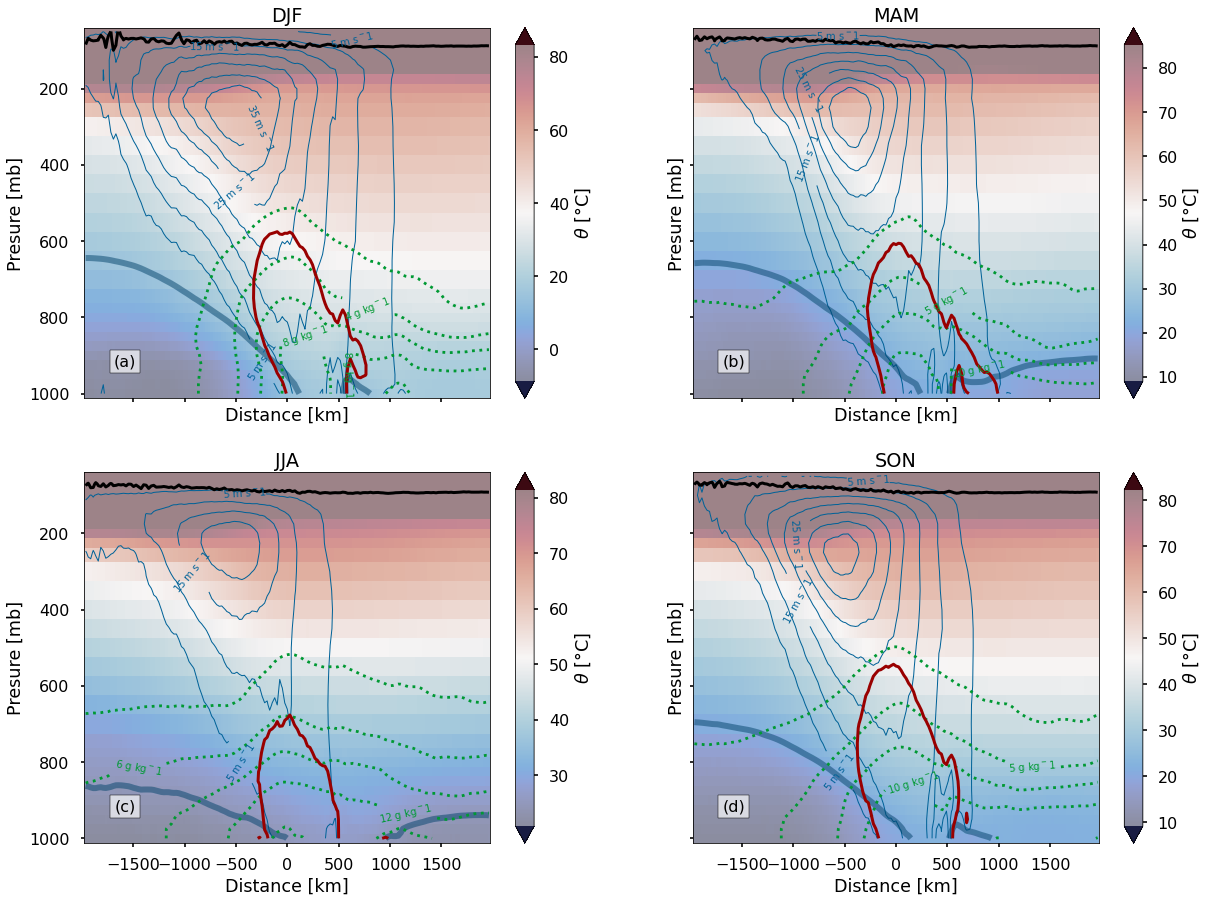

In [7]:
""" Plot a transect of the atmospheric conditions """
clat, clon = 41.8781, 360-87.6298

# the transect line
m = -0.45
dlon = 20
transect_a_lat = blat - m*dlon
transect_b_lat = blat + m*dlon
transect_a_lon = blon - dlon
transect_b_lon = blon + dlon
delta_lon = 0.25
lon_interp = np.arange(transect_a_lon, transect_b_lon + delta_lon, delta_lon)
lat_interp = m*lon_interp + (transect_a_lat - m*transect_a_lon)

# set the distances along the line
total_d = great_circle_distance(transect_a_lat, transect_a_lon, transect_b_lat, transect_b_lon)
distances = np.linspace(-total_d/2, total_d/2, len(lat_interp))


# create an xarray dataarray out of the x/y coordinates to which we'll interpolate
lon_interp_da = xr.DataArray(lon_interp, dims = 'distance', coords = dict(distance = distances))
lat_interp_da = xr.DataArray(lat_interp, dims = 'distance')

# determine the unit normal vector to the transect, for calculating winds through the transect
normal_slope = -1/m
normal_vector_y = normal_slope
normal_vector_x = 1
normal_vector_magnitude = np.sqrt(normal_slope**2 + 1)
normal_vector_x /= normal_vector_magnitude
normal_vector_y /= normal_vector_magnitude


# set the plot labels
plot_labels = "a b c d".split()

fig, axs = plt.subplots(2,2,figsize = (20,15), sharex = True, sharey = True)

for i,season in enumerate(seasons[:-1]):
    
    ax = axs.ravel()[i]

    #transect_xr = comp_xr_subset.sel(season = season).sel(longitude = clon, method = 'nearest')
    transect_xr = comp_xr_subset.sel(season = season).interp(latitude = lat_interp_da, longitude = lon_interp_da)
    

    # **************
    # wind contours
    # **************
    Unorm = normal_vector_x * transect_xr['U'] + normal_vector_y * transect_xr['V']
    CS = Unorm.plot.contour(
        ax = ax,
        colors = ["#006298"],
        levels = np.arange(5,60,5),
        linewidths = 1,
    )
    def fmt(x):
        return f"{int(x)} m s$^{-1}$"
    ax.clabel(CS, CS.levels[::2], inline=True, fmt=fmt)#, fontsize=10)

    # ************
    # temperature
    # ************
    theta = transect_xr['theta'] - 273.15
    thmin = float(theta.sel(distance = -1500, level = 1000, method = 'nearest').values)
    thmax = float(theta.sel(distance = 1500, level = 150, method = 'nearest').values)
    theta.plot(
        ax = ax,
        cmap = cmocean.cm.balance,
        vmin = thmin, vmax = thmax,
        alpha = 0.5,
        cbar_kwargs = dict(label = r"$\theta$ [°C]"),
    )

    # ***********
    # frontal zone
    # *************
    i_max_grad = transect_xr['theta'].differentiate('distance').argmin(dim = 'distance')
    #lat_max_grad = transect_xr['latitude'].isel(latitude = i_max_grad)
    # find the surface temperature at the point of the maximum gradient; use this as the theta contour
    t_max_grad = float(theta.isel(distance = i_max_grad.sel(level = 1000).values).sel(level = 1000).values)
    theta.plot.contour(
        ax = ax,
        colors = ["#01426A"],
        linewidths = [6],
        linestyles = ['-'],
        alpha = 0.5,
        levels = [t_max_grad],
    )


    # *********
    # humidity
    # *********
    CS = transect_xr['Q'].plot.contour(
        ax = ax,
        linestyles = [':'],
        colors = ["#009933"],
    )
    def fmt(x):
        return f"{int(x)} g kg$^{-1}$"
    ax.clabel(CS, CS.levels[::2], inline=True, fmt=fmt)#, fontsize=10)

    # ***********
    # tropopause
    # ***********
    transect_xr['PV'].T.plot.contour(
        ax = ax,
        colors = ["black"],
        linewidths = [3],
        levels = [2],
    )


    # **************
    # moisture flux
    # **************
    qu = transect_xr['Q'] * Unorm 
    qu.plot.contour(
        ax = ax,
        colors = ["#990000"],
        linewidths = [3],
        levels = [60],
    )
    

    ax.set_ylabel("Presure [mb]")
    ax.set_xlabel("Distance [km]")
    #ax.invert_xaxis()
    ax.invert_yaxis()

    # set the title
    ax.set_title(str(season.values))
    
    # add the plot label
    ax.text(0.1, 0.1,
            f"({plot_labels[i]})",
            fontsize = 16,
            bbox=dict(facecolor='#FFFFFFAA', edgecolor='black'),
            ha='center', va='center', 
            transform = ax.transAxes)

plt.savefig('fig_transect_composites.pdf', bbox_inches = 'tight')
plt.savefig('fig_transect_composites.png', bbox_inches = 'tight', dpi = 300)
plt.show()

**Caption:** Composite transects of potential temperature (shading), transect-normal winds (blue curves), specific humidity (dotted green curves), moisture flux at the 60 g m kg$^{-1}$ s$^{-1}$ level (red contour), and the 2 PVU potential vorticity contour (black curve) for AR conditions over Bloomington, IN in (a) DJF, (b) MAM, (c) JJA, and (d) SON. Thick, transparent blue curves in all four panels show frontal zones.

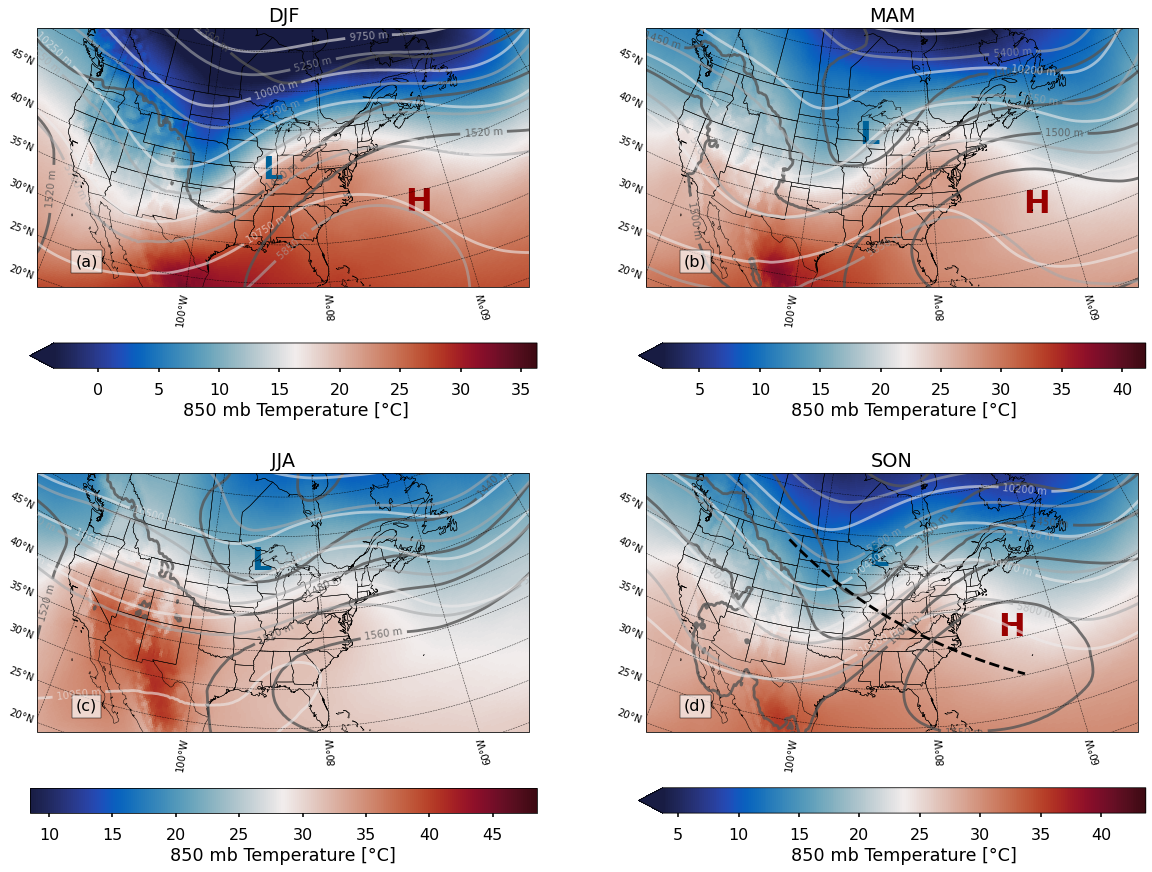

In [8]:
""" Plot T850, Z850, Z200 and the low """

clat, clon = 41.8781, 360-87.6298
projection = cartopy.crs.LambertConformal(central_latitude = blat, central_longitude = blon)
transform = cartopy.crs.PlateCarree()

fig, axs = plt.subplots(2,2,figsize = (20,15), subplot_kw = dict(projection = projection))

for i,season in enumerate(seasons[:-1]):
    
    ax = axs.ravel()[i]

    ax.set_extent([blon - half_lon_width, blon + half_lon_width, blat - half_lat_width, blat + half_lat_width], crs = cartopy.crs.PlateCarree())
    

    level = 850
    tmid = float(T.sel(latitude = clat, longitude = clon, level = level, method = 'nearest').sel(season = season).values)
    tspan = 20
    T.sel(season = season, level = level).plot(ax = ax, transform = transform, cmap = cmocean.cm.balance,
                           vmin = tmid-tspan, vmax = tmid+tspan, 
                            cbar_kwargs = dict(label = f"{level} mb Temperature [°C]", orientation = 'horizontal'))

    CS = Z.sel(season = season, level = 850).plot.contour(ax = ax, transform = transform, colors = "#55555599", alpha = 0.8)
    fmt = lambda x : f"{int(x)} m"
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt)#, fontsize=10)
    
    CS = Z.sel(season = season, level = 500).plot.contour(ax = ax, transform = transform, colors = "#A7A9AB99")
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt)#, fontsize=10)

    CS = Z.sel(season = season, level = 250).plot.contour(ax = ax, transform = transform, colors = "#EDEBEB99")
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt)#, fontsize=10)
    
    # add an L near the surface low
    slp_midwest = slp.sel(season = season, longitude = slice(360-100, 360-80), latitude = slice(50, 35))
    nmin = slp_midwest.argmin()
    imin, jmin = np.unravel_index(nmin.values, slp_midwest.shape)
    lat_slp_min = float(slp_midwest.latitude.isel(latitude = imin).values)
    lon_slp_min = float(slp_midwest.longitude.isel(longitude = jmin).values)
    ax.text(lon_slp_min, lat_slp_min,
            "L",
            transform = transform,
            color = "#006298",
            fontdict = dict(size = 32, weight = 'bold'),
            ha='center', va='center', 
            zorder = 1)
    
    # add an H near the surface low
    slp_atlantic = slp.sel(season = season, longitude = slice(360-85, 360-55), latitude = slice(45, 25))
    nmax = slp_atlantic.argmax()
    imax, jmax = np.unravel_index(nmax.values, slp_atlantic.shape)
    lat_slp_max = float(slp_atlantic.latitude.isel(latitude = imax).values)
    lon_slp_max = float(slp_atlantic.longitude.isel(longitude = jmax).values)
    if(lon_slp_max != (360 - 55)):
        ax.text(lon_slp_max, lat_slp_max,
                "H",
                transform = transform,
                color = "#990000",
                fontdict = dict(size = 32, weight = 'bold'),
                ha='center', va='center', 
                zorder = 1)
        
        
    # plot the transect line
    if i == 3:
        ax.plot(lon_interp, lat_interp, color = "black", linestyle = '--', transform = transform)
        

    ax.gridlines(auto_inline = False, draw_labels = dict(bottom="x", left="y"), linewidth = 0.5, alpha = 0.8, color = 'black', linestyle = '--')
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    ax.set_title(str(season.values))
    
    # add the plot label
    ax.text(0.1, 0.1,
            f"({plot_labels[i]})",
            fontsize = 16,
            bbox=dict(facecolor='#FFFFFFAA', edgecolor='black'),
            ha='center', va='center', 
            transform = ax.transAxes)

    
plt.savefig('fig_dynamic_composites.pdf', bbox_inches = 'tight')
plt.savefig('fig_dynamic_composites.png', bbox_inches = 'tight', dpi = 300)
plt.show()                       

**Caption:** Composite maps of 850 mb temperature (shading), 850 mb heights (dark gray contours), 500 mb heights (light gray contours), 250 mb heights (white contours), and surface low and high presures (L and H symbols) for AR conditions over Bloomington, IN in (a) DJF, (b) MAM, (c) JJA, and (d) SON.  The dashed black curve in (d) shows the location of the transect.

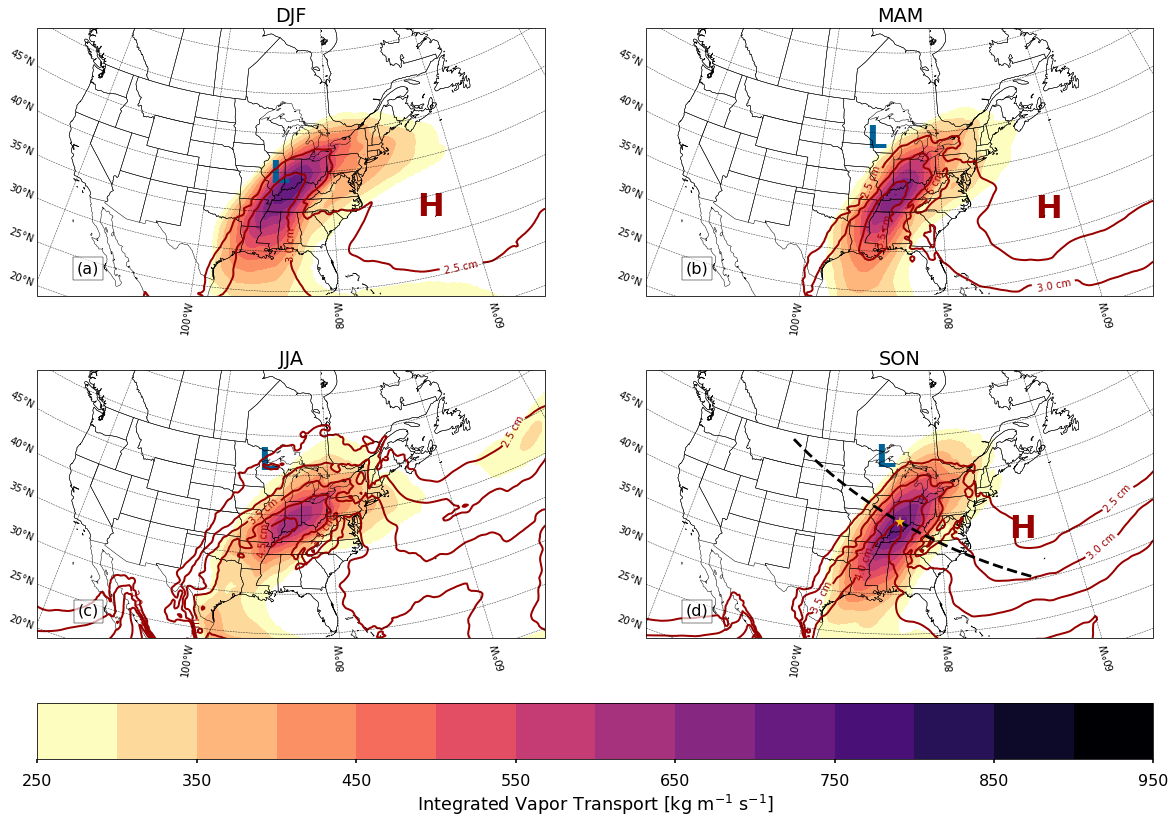

In [9]:
""" Plot IVT, Z500 and SLP """

clat, clon = 41.8781, 360-87.6298
projection = cartopy.crs.LambertConformal(central_latitude = blat, central_longitude = blon)
transform = cartopy.crs.PlateCarree()

fig, axs = plt.subplots(2,2,figsize = (20,15), subplot_kw = dict(projection = projection))

for i,season in enumerate(seasons[:-1]):
    
    ax = axs.ravel()[i]

    ax.set_extent([blon - half_lon_width, blon + half_lon_width, blat - half_lat_width, blat + half_lat_width], crs = cartopy.crs.PlateCarree())
    
    # ****
    # IVT
    # ****
    ivt_masked = ivt.where(ivt >= 250)
    cplt = ivt_masked.sel(season = season).plot.contourf(
        ax = ax,
        cmap = 'magma_r',
        levels = np.arange(250,1000, 50),
        transform = transform,
        add_colorbar = False,
    )
        
    
    # ****
    # IWV
    # ****
    CS = iwv.sel(season = season).plot.contour(
        ax = ax,
        levels = [2.5,3,3.5,4,4.5,5,5.5,6],
        colors = "#990000",
        linewidths = 2,
        transform = transform,
    )
    fmt = lambda x : f"{float(x)} cm"
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt)#, fontsize=10)
    
    
    # add an L near the surface low
    slp_midwest = slp.sel(season = season, longitude = slice(360-100, 360-80), latitude = slice(50, 35))
    nmin = slp_midwest.argmin()
    imin, jmin = np.unravel_index(nmin.values, slp_midwest.shape)
    lat_slp_min = float(slp_midwest.latitude.isel(latitude = imin).values)
    lon_slp_min = float(slp_midwest.longitude.isel(longitude = jmin).values)
    ax.text(lon_slp_min, lat_slp_min,
            "L",
            transform = transform,
            color = "#006298",
            fontdict = dict(size = 32, weight = 'bold'),
            ha='center', va='center', 
            zorder = 1)
    
    # add an H near the surface low
    slp_atlantic = slp.sel(season = season, longitude = slice(360-85, 360-55), latitude = slice(45, 25))
    nmax = slp_atlantic.argmax()
    imax, jmax = np.unravel_index(nmax.values, slp_atlantic.shape)
    lat_slp_max = float(slp_atlantic.latitude.isel(latitude = imax).values)
    lon_slp_max = float(slp_atlantic.longitude.isel(longitude = jmax).values)
    if(lon_slp_max != (360 - 55)):
        ax.text(lon_slp_max, lat_slp_max,
                "H",
                transform = transform,
                color = "#990000",
                fontdict = dict(size = 32, weight = 'bold'),
                ha='center', va='center', 
                zorder = 1)
        
    ax.gridlines(auto_inline = False, draw_labels = dict(bottom="x", left="y"), linewidth = 0.5, alpha = 0.8, color = 'black', linestyle = '--')
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    ax.set_title(str(season.values))
    
    # add the plot label
    ax.text(0.1, 0.1,
            f"({plot_labels[i]})",
            fontsize = 16,
            bbox=dict(facecolor='#FFFFFFAA', edgecolor='black'),
            ha='center', va='center', 
            transform = ax.transAxes)
    
    # plot the transect line
    if i == 3:
        ax.plot(lon_interp, lat_interp, color = "black", linestyle = '--', transform = transform)
        ax.plot(blon, blat, color = "#F5BB17", linestyle = '--', marker = '*', transform = transform)
        
    
    
fig.colorbar(cplt, ax = axs.ravel(), label = "Integrated Vapor Transport [kg m$^{-1}$ s$^{-1}$]", orientation = 'horizontal', pad = 0.08)
plt.savefig('fig_moisture_composites.pdf', bbox_inches = 'tight')
plt.savefig('fig_moisture_composites.png', bbox_inches = 'tight', dpi = 300)

plt.show()                       

**Caption:** Composite maps of integrated vapor transport (shading), total column water vapor (red contours), and surface low and high presures (L and H symbols) for AR conditions over Bloomington, IN in (a) DJF, (b) MAM, (c) JJA, and (d) SON.  The dashed black curve in (d) shows the location of the transect. The dashed black curve in (d) shows the location of the transect.